In [1]:
USE_GPU = True
GPU_ID = "3" # the gpu to use for this job
if USE_GPU:
    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = GPU_ID

In [2]:
import tensorflow as tf
# Suppress tensorflow 1.x deprecation warnings.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
# Initialize logger to view logging output from segmentation tasks
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
from google.protobuf import text_format
from ffn.inference import inference
from ffn.inference import inference_pb2

In [5]:
from fftracer.utils.config import InferenceConfig

# To change inference settings, modify the relevant parameters here.

inference_config = InferenceConfig(
    image="data/test/507727402/507727402_raw.h5:raw", fov_size={"x": 135, "y": 135, "z": 1},
    deltas={"x": 8, "y": 8, "z": 0}, depth=9, image_mean=78, image_stddev=20,
    model_checkpoint_path="training-logs/lr0.001depth9fov135/model.ckpt-3827778",
    model_name="fftracer.training.models.model.FFNTracerModel",
    segmentation_output_dir="results/mozak", move_threshold=0.1,
    min_boundary_dist={"x": 1, "y": 1, "z": 0}
)
config = inference_config.to_string()

In [6]:
req = inference_pb2.InferenceRequest()
_ = text_format.Parse(config, req)

In [7]:
runner = inference.Runner()
runner.start(req)
# Canvas sizes in (z, y, x); order is (top_left); (bottom_right)
## Full canvas:
## canvas, alignment = runner.make_canvas((0, 0, 0), (1, 9429, 7601))
canvas, alignment = runner.make_canvas((0, 0 ,2000), (1, 6000, 7601))

/homes/gws/jpgard/ffn/ffn/inference/storage.py:62: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  volume = h5py.File(path[0])[path[1]]
INFO:root:Available TF devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 7355155453694339337), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10093722641003145114), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 3868815037387406644), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 8357239194, 14872510196181549899)]
INFO:root:Importing symbol FFNTracerModel from ffn.training.models.fftracer.training.models.mod

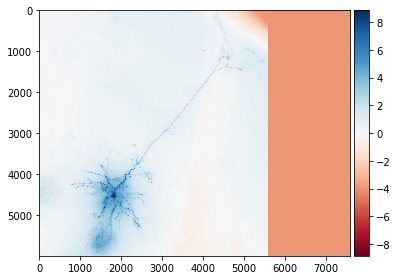

In [8]:
# Show the input image data stored in the canvas.
from skimage.io import imshow
from matplotlib import pyplot as plt
imshow(canvas.image[0,:,:])
plt.show()


In [9]:
# Create a single segment, starting from the specified origin point.
canvas.segment_at(
#     (0, 4521, 3817),  # seed starting point in (z, y, x)
    (0, 4521-(9431-6000), 3817 - (7601-2000)),
    dynamic_image=inference.DynamicImage(),
    vis_update_every=50,
    vis_fixed_z=True
)

0

In [ ]:
from ffn.inference.seed import PolicyPeaks2d
canvas.segment_all(seed_policy=PolicyPeaks2d)

In [ ]:
# read the results
import numpy as np
seg_prob = np.load("results/mozak/0/0/seg-0_0_0.prob")['qprob']
print("shape: {}".format(seg_prob.shape))
seg_prob